In [1]:
import scanpy as sc

In [2]:
import pickle

In [3]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt

In [6]:
import sys
import os
from importlib import reload

# Add the path of your package
package_path = os.path.abspath("/Genomics/pritykinlab/tamjeed/github_packages/GlossPath/")
sys.path.insert(0, package_path)
package_path = os.path.abspath("/Genomics/pritykinlab/tamjeed/github_packages/Gloss/")
sys.path.insert(0, package_path)

In [7]:
def generate_pathways_dict(fn, mygenes, change_case = False):
    pathways = {}
    with open(fn, "r") as f:
        for line in f:
            line = line.strip()
            words = line.split("\t")
            if change_case:
                words = [ word.capitalize() for word in words]
            pathway = words[2:]
            pathway = list(set(pathway).intersection(mygenes))
            pathways[words[0]] = pathway
            #if len(pathway) < 200 and len(pathway) > 3:
            #    pathways[words[0]] = pathway
    return pathways

In [8]:
def get_hallmark_pathways(gene_ad):
    hallmark_pathways_path = '../pathway_collections/mouse_hallmark_genes.gmt.txt'
    mygenes = set(gene_ad.var.index)
    path_dict = generate_pathways_dict(hallmark_pathways_path, mygenes)
    return path_dict

def get_kegg_pathways(gene_ad):
    with open('../pathway_collections/kegg_pathways_sep18_2024.pkl', 'rb') as handle:
        kegg_gene_sets = pickle.load(handle)
    
    mygenes = set(gene_ad.var.index)
    for key, value in kegg_gene_sets.items():
        kegg_gene_sets[key] = list(set([gene for gene in value if gene in mygenes]))
        
    empty = []
    for key in kegg_gene_sets:
        if not kegg_gene_sets[key]:
            empty.append(key)

    for pathway in empty:
        kegg_gene_sets.pop(pathway)
        
    path_dict = kegg_gene_sets
    return path_dict

In [9]:
with open('../pathway_computations/cellchatdb.pickle', 'rb') as handle:
    cellchatdb = pickle.load(handle)
with open('../pathway_computations/cd40neighbors.pickle', 'rb') as handle:
    cd40neighbors = pickle.load(handle)

In [10]:
with open('../pathway_computations/random_neighbors.pickle', 'rb') as handle:
    random_neighbors = pickle.load(handle)

In [11]:
with open('../pathway_computations/humanbase_cd40neighbors.pickle', 'rb') as handle:
    humanbase_cd40neighbors = pickle.load(handle)

In [12]:
with open('../pathway_computations/cd40_filtered.pickle', 'rb') as handle:
    cd40_filtered_neighbors = pickle.load(handle)

In [85]:
with open('../pathway_computations/noncd40_perturbed_genes.pickle', 'rb') as handle:
    noncd40_perturbed_genes = pickle.load(handle)

In [13]:
from GlossPath.prepdata import PrepData

In [14]:
prepped_datas = {}
for i in range(10):
    print(i)
    datapath = 'datasets/{}_lipstic_tumor_data_perturbed_filtered_binned_v3_oct_25_2024.h5ad'.format(i)
    prepped_datas[i] = PrepData(datapath, 'hallmark', 'hash_max', 'nCount_RNA', 'biotin_raw_perturbed')

0
1
2
3
4
5
6
7
8
9


In [15]:
l_tumor_adatas = {}
for i in range(10):
    l_tumor_adatas[i] = prepped_datas[i].adata

In [16]:
datasets = {
    #'gut' : gut_ad,
    #'lcmv_sys' : lcmv_sys_ad,
    #'lcmv_ln' : lcmv_ln_ad,
    'l_tumor' : l_tumor_adatas,
}

In [17]:
datasets['l_tumor']

{0: AnnData object with n_obs × n_vars = 10346 × 10898
     obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.mt.log2', 'nCount_HTO', 'nFeature_HTO', 'nCount_ADT', 'nFeature_ADT', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'SCT_snn_res.0.6', 'SCT_snn_res.0.7', 'SCT_snn_res.0.8', 'SCT_snn_res.0.9', 'SCT_snn_res.1', 'seurat_clusters', 'Hash', 'Enrichment', 'Ab_Group', 'S.Score', 'G2M.Score', 'Phase', 'Phase2', 'Biotin_Group2', 'Biotin_Ab_Group', 'Lipstic1', 'hash_max', 'hash_id', 'biotin_raw', 'n_counts', 'new_biotin', 'other_new_biotin', 'log_sample_hashtag', 'log_RNA_libsize', 'annotation', 'annotation_fine', 'biotin_raw_perturbed'
     var: 'name', 'n_counts', 'mean', 'std'
     uns: 'log1p', 'pearson_residuals_normalization'
     obsm: 'X_pca', 'X_umap'
     layers: 'log_lib_norm', 'raw_counts', 'theta_1', 'log_scaled',


In [18]:
## coefficients

# uLIPSTIC gut
#with open('../model_ulipstic_gut/experiment_evaluations/gut_glosspath_bootstrap_hallmark_oct9_2024.pickle', 'rb') as handle:
#    gut_glasso_res = pickle.load(handle)
# uLIPSTIC lcmv sys
#with open('../model_ulipstic_lcmv/experiment_evaluations/', 'rb') as handle:
#    lcmv_sys_glasso_res = pickle.load(handle)
# uLIPSTIC lcmv ln
#with open('../model_ulipstic_lcmv/experiment_evaluations/grouplasso_hallmark_bootstrap_u_lcmv_ln_oct3_2024.pickle', 'rb') as handle:
#    lcmv_ln_glasso_res = pickle.load(handle)
# LIPSTIC tumor

lipstic_tumor_perturb_bootstraps = {}
for i in range(10):
    print(i)
    with open('../model_lipstic_tumor/experiment_evaluations/{}_tumor_perturbed_filtered_binned_v3_new_gloss_bootstrap_hallmark_oct25_2024.pickle'.format(i), 'rb') as handle:
        lipstic_tumor_perturb_bootstraps[i] = pickle.load(handle)

0
1
2
3
4
5
6
7
8
9


In [19]:
lipstic_tumor_perturb_bootstraps[0].response_individual_genes['annotation_fine']['Mo/MF']

,Rps9,Ear2,Gsr,Gbp2b,Cd44,Aldh2,Il6,Sap30,F10,Myd88,...,Cxcl9,Clta,C3,Rpl27a,Cox6c,Rps11,Cxcl16,Sdc4,H2-K1,log
0,-0.030736,-0.004977,-0.001552,-0.000875,-0.003566,-0.004103,-0.005927,-0.001692,-0.003417,-0.006836,...,0.025431,0.011241,0.014529,0.012326,0.002598,0.010137,0.013462,0.008224,0.039438,0.104411
1,-0.006808,-0.009465,-0.003456,-0.007816,-0.001961,-0.002661,-0.005880,-0.000868,-0.002002,-0.002487,...,0.008000,0.005454,0.010998,0.018261,0.009041,0.018279,0.011476,0.012472,0.048443,0.097675
2,-0.002312,-0.008839,-0.003137,-0.001146,-0.004552,-0.003109,-0.001946,-0.005545,-0.002419,-0.001545,...,0.004983,0.002843,0.010720,0.002498,0.021171,0.016979,0.020658,0.013474,0.048642,0.096516
3,-0.021894,-0.008689,-0.003580,-0.006786,-0.002270,-0.000517,-0.003291,-0.005078,-0.002321,-0.002949,...,0.010055,0.012761,0.011663,0.015326,0.010319,0.011653,0.014481,0.011921,0.059298,0.106297
4,-0.010031,-0.011432,-0.006318,-0.011187,-0.004433,-0.005323,0.000018,-0.000842,-0.004196,-0.002491,...,0.005826,0.004710,0.010473,0.011150,0.020676,0.014171,0.021420,0.008460,0.051952,0.113946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.017534,-0.006491,-0.004358,-0.000254,-0.003378,-0.003168,-0.003331,-0.001948,-0.002907,-0.005501,...,0.009936,0.008990,0.012670,0.014282,0.011512,0.014393,0.008443,0.019487,0.038024,0.112329
96,-0.011735,-0.003469,-0.003243,-0.006173,-0.003194,-0.003038,-0.002769,-0.002633,-0.001881,-0.005740,...,0.009776,0.013892,0.008322,0.027881,0.002789,0.014669,0.033406,0.010667,0.050712,0.113707
97,-0.017567,-0.004378,-0.005582,-0.005677,-0.001793,-0.004572,-0.008629,-0.000495,-0.001496,-0.001626,...,0.007498,0.007360,0.016018,0.003511,0.014863,0.009687,0.019343,0.008595,0.061206,0.106436
98,-0.008141,-0.006652,-0.000582,-0.007570,-0.004893,-0.006306,-0.001356,-0.003108,-0.001924,-0.002688,...,0.008422,0.001701,0.008469,0.003203,0.024769,0.022269,0.013874,0.010636,0.051717,0.098226


In [20]:
lipstic_tumor_perturb_bootstraps[5].response_individual_genes['annotation_fine']['Mo/MF']

,Ear2,Gsr,Rps9,Bpgm,Gbp2b,Myd88,Ace,F10,Il6,Klk8,...,Vdr,Cd40,Cxcl16,Cxcl9,C3,Psma7,AA467197,Arf1,Ass1,log
0,-0.006399,-0.002279,-0.025249,-0.004383,-0.000509,-0.007911,-0.003484,-0.005150,-0.005927,-0.001343,...,0.008098,0.009124,0.006369,0.026557,0.013392,0.016164,0.022593,0.015106,0.029579,0.108135
1,-0.009851,-0.004982,-0.007146,-0.004714,-0.007343,-0.003091,-0.002416,-0.002271,-0.003941,-0.001022,...,0.003031,0.006528,0.008288,0.011938,0.012057,0.024218,0.015174,0.022434,0.018665,0.102968
2,-0.008253,-0.007251,-0.002456,-0.003872,0.000000,-0.003002,-0.001610,-0.003060,-0.002662,-0.000653,...,0.002167,0.007265,0.012314,0.005702,0.008621,0.016382,0.018713,0.027006,0.026927,0.088692
3,-0.010881,-0.005392,-0.013172,-0.005125,-0.008297,-0.003778,-0.002015,-0.003388,-0.003771,-0.005114,...,0.006821,0.007368,0.003858,0.010356,0.011639,0.015850,0.010284,0.023171,0.035287,0.102066
4,-0.010314,-0.007571,-0.005976,-0.005633,-0.011834,-0.003401,-0.003585,-0.004152,-0.001441,-0.003338,...,0.000293,0.007735,0.014636,0.006990,0.008105,0.019626,0.012413,0.013654,0.034451,0.120664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.006679,-0.006369,-0.008025,-0.002277,0.000000,-0.006123,-0.008512,-0.004540,-0.003017,-0.004346,...,0.006233,0.008656,0.005974,0.010775,0.012964,0.004347,0.006784,0.012339,0.023741,0.125024
96,-0.003663,-0.003189,-0.001702,-0.005391,-0.004113,-0.009426,-0.010331,-0.003090,-0.004371,-0.006641,...,0.010498,0.007523,0.024661,0.011274,0.009754,0.015874,0.017226,0.013503,0.025962,0.107153
97,-0.004092,-0.006934,-0.014316,-0.002926,-0.003027,-0.003040,-0.000075,-0.001952,-0.005813,-0.004565,...,0.005909,0.005834,0.018115,0.007441,0.013584,0.009201,0.011737,0.014299,0.021424,0.104486
98,-0.006640,-0.004008,-0.003128,-0.004142,-0.006792,-0.003898,-0.003218,-0.003064,-0.001532,-0.003202,...,0.017445,0.006437,0.008606,0.008668,0.007729,0.014505,0.015883,0.028234,0.013405,0.094553


In [21]:
lipstic_tumor_perturb_bootstraps[3].response_individual_genes['annotation_fine']['Mo/MF']

,Rps9,Ear2,Ifngr1,F10,Rps3a1,Gbp2b,Plau,Gsr,Map2k3,Aldh2,...,Inhba,Fcgr2b,Cd40,Gnas,Cxcl9,Rpl15,C3,Cxcl16,Rpl41,log
0,-0.028629,-0.003050,-0.000952,-0.006733,-0.002651,-0.000508,-0.005231,-0.001841,-0.002472,-0.004478,...,0.004048,0.014265,0.008797,0.008605,0.022677,0.001201,0.012873,0.012475,0.031710,0.108243
1,-0.007145,-0.007651,-0.003980,-0.003557,-0.003582,-0.009643,-0.001721,-0.002780,-0.003653,-0.002739,...,0.006380,0.004642,0.007887,0.009443,0.009687,0.015277,0.010972,0.016957,0.025520,0.103531
2,-0.004065,-0.008949,-0.005738,-0.003912,-0.003957,0.000000,-0.002359,-0.006156,-0.000650,-0.004626,...,0.005995,0.003495,0.007466,0.004683,0.006096,0.016392,0.011401,0.019625,0.024117,0.088341
3,-0.015954,-0.008689,-0.001492,-0.004322,-0.003024,-0.006886,-0.001173,-0.002800,-0.001752,-0.000935,...,0.006468,0.004440,0.008172,0.009262,0.009732,0.015590,0.012084,0.014890,0.028067,0.092552
4,-0.010993,-0.012498,-0.004937,-0.004141,-0.004683,-0.010557,-0.004756,-0.006711,-0.006046,-0.003108,...,0.006493,0.006106,0.008926,0.019896,0.007106,0.002234,0.009937,0.022211,0.039281,0.116436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.019327,-0.005924,-0.002801,-0.006416,-0.002177,-0.000439,-0.004260,-0.006024,-0.003952,-0.002283,...,0.006418,0.009043,0.010584,0.011869,0.010041,0.006029,0.014294,0.010697,0.042670,0.113590
96,-0.008814,-0.004043,-0.002436,-0.003588,-0.003533,-0.003845,-0.002848,-0.002384,-0.006009,-0.002078,...,0.009056,0.004396,0.008328,0.008218,0.010030,0.012158,0.010949,0.033495,0.041741,0.109090
97,-0.018642,-0.005194,-0.005796,-0.002749,-0.004119,-0.003371,-0.004752,-0.005876,-0.003794,-0.004232,...,0.005105,0.004099,0.009566,0.016453,0.007421,0.006381,0.015259,0.020101,0.034118,0.093357
98,-0.008674,-0.007162,-0.004047,-0.003688,-0.004544,-0.004536,-0.003031,-0.000757,-0.003289,-0.002360,...,0.006442,0.004507,0.008875,0.003869,0.010342,0.015773,0.009459,0.012603,0.037302,0.096666


In [22]:
l_tumor_coefficient_results = {}
for i in range(10):
    l_tumor_coefficient_results[i] = lipstic_tumor_perturb_bootstraps[i].response_individual_genes

In [23]:
coefficient_results = {
    #'gut' : gut_glasso_res.response_individual_genes,
    #'lcmv_sys' : lcmv_sys_glasso_res,
    #'lcmv_ln' : lcmv_ln_glasso_res,
    'l_tumor' : l_tumor_coefficient_results
}

In [24]:
resolution_subsets = {

'l_tumor' : {
    'annotation_fine' : ['Mo/MF', 'cDC2', 'mRegDC2']
}

}

In [25]:
def make_corr_df(ad, norm_layer, biotin_norm=False):
    genes = ad.var_names
    spearman_rhos = []
    gene_vals = ad.layers[norm_layer].toarray()
    print(gene_vals.shape)
    if not biotin_norm:
        biotin_vals = ad.obs['new_biotin']
    else:
        biotin_vals = ad.obs['other_new_biotin']
    for i, g in enumerate(genes):
        mygene = gene_vals[:,i]
        spearman_rhos.append(spearmanr(biotin_vals, mygene))
    df = pd.DataFrame({"gene": genes, 
                       "corr": [ c[0] for c in spearman_rhos],
                       "sig": [ c[1] for c in spearman_rhos],
                      })
    
    df["top gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=False).head(n=10)["gene"]) + 
    list(df.sort_values("corr", ascending=True).head(n=10)["gene"]))
    df["top 30 corr gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=False).head(n=30)["gene"]))
    df["top 30 anticorr gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=True).head(n=30)["gene"]))
    df = df.sort_values("corr") 
    df["i"] = [i/10 for i in range(len(genes))]
    
    df['is_FDR_sig'] = multipletests(df['sig'], method='bonferroni', alpha=0.01)[0]
    df['corrected_sig'] = multipletests(df['sig'], method='bonferroni', alpha=0.01)[1]
    df.dropna(inplace=True)
    return df

In [26]:
datasets['l_tumor']

{0: AnnData object with n_obs × n_vars = 10346 × 10898
     obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.mt.log2', 'nCount_HTO', 'nFeature_HTO', 'nCount_ADT', 'nFeature_ADT', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'SCT_snn_res.0.6', 'SCT_snn_res.0.7', 'SCT_snn_res.0.8', 'SCT_snn_res.0.9', 'SCT_snn_res.1', 'seurat_clusters', 'Hash', 'Enrichment', 'Ab_Group', 'S.Score', 'G2M.Score', 'Phase', 'Phase2', 'Biotin_Group2', 'Biotin_Ab_Group', 'Lipstic1', 'hash_max', 'hash_id', 'biotin_raw', 'n_counts', 'new_biotin', 'other_new_biotin', 'log_sample_hashtag', 'log_RNA_libsize', 'annotation', 'annotation_fine', 'biotin_raw_perturbed'
     var: 'name', 'n_counts', 'mean', 'std'
     uns: 'log1p', 'pearson_residuals_normalization'
     obsm: 'X_pca', 'X_umap'
     layers: 'log_lib_norm', 'raw_counts', 'theta_1', 'log_scaled',


In [27]:
corr_results = {}

for i in range(10):
    print(i)
    corr_results[i] = {}
    for data in resolution_subsets:
        print(data)
        corr_results[i][data] = {}
        for resolution in resolution_subsets[data]:
            corr_results[i][data][resolution] = {}
            for ctype in resolution_subsets[data][resolution]:
                corr_results[i][data][resolution][ctype] = make_corr_df(datasets[data][i][datasets[data][i].obs[resolution] == ctype], norm_layer='log_lib_norm', biotin_norm=True)

0
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


5
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


6
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


7
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


8
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


9
l_tumor
(2656, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(1730, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(4326, 10898)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [28]:
corr_results

{0: {'l_tumor': {'annotation_fine': {'Mo/MF':           gene      corr           sig  top gene  top 30 corr gene  \
    4539      Rps9 -0.205999  7.627411e-27      True             False   
    3223   Alox5ap -0.188182  1.356544e-22      True             False   
    6486      Ear2 -0.171356  5.962020e-19      True             False   
    6385      Tpt1 -0.168175  2.655963e-18      True             False   
    10243    Rps14 -0.161475  5.620338e-17      True             False   
    ...        ...       ...           ...       ...               ...   
    3425     Cxcl9  0.220403  1.397147e-30      True              True   
    1128      Cd40  0.221179  8.630453e-31      True              True   
    9676     H2-K1  0.239630  5.327209e-36      True              True   
    7850    Cxcl16  0.249760  4.672964e-39      True              True   
    1068      Sdc4  0.259923  2.882825e-42      True              True   
    
           top 30 anticorr gene       i  is_FDR_sig  corrected_si

In [127]:
dataset = 'l_tumor'
res = 'annotation_fine'
ctype = 'mRegDC2'

In [128]:
i = 0

In [129]:
# filter a dict to only include genes in that data

test_ad = datasets[dataset][i]
coef = coefficient_results[dataset][i][res][ctype].drop('log', axis=1)
corr = corr_results[i][dataset][res][ctype]

# run the enrichment over correlations or coefficients

In [130]:
mycoefs = coef 
mycoefs.columns[-50:]

Index(['Ndrg1', 'Btla', 'Uqcr11', 'Lmo2', 'Smarcc1', 'Prps1', 'Mvp', 'Mylk',
       'Dpysl5', 'Inpp5b', 'Irs2', 'Snrpd1', 'Acadm', 'Atp2b1', 'Glrx', 'Rpl6',
       'Psmb2', 'Srp14', 'Fas', 'Cxcl9', 'Icam1', 'Prdx3', 'Elovl5', 'Tyms',
       'Rbbp8', 'Capg', 'Cish', 'Cdkn1a', 'Cbx3', 'Prdx1', 'Vdr', 'Oasl1',
       'Tmem131', 'Tspo', 'Il6', 'Lrrfip1', 'Spcs1', 'Cox6c', 'Txn1', 'Ccnd2',
       'Vim', 'Irf8', 'Sema7a', 'Rpl27a', 'Ccl22', 'Rps11', 'H2-K1', 'Clta',
       'Procr', 'Cd40'],
      dtype='object')

In [131]:
mypathdict = {}
mypathdict.update(cd40neighbors.copy())
mypathdict.update(cellchatdb.copy())
mypathdict.update(humanbase_cd40neighbors.copy())
mypathdict.update(random_neighbors.copy())
mypathdict.update(cd40_filtered_neighbors.copy())
mypathdict.update(noncd40_perturbed_genes.copy())

for key in mypathdict:
    mypathdict[key] = list(set(mypathdict[key]).intersection(test_ad.var.index))

In [132]:
mypathdict

{'cd40_and_neighbors': ['Alox5',
  'Il2ra',
  'Atp5e',
  'Fbl',
  'Ccr5',
  'Mag',
  'Khdrbs1',
  'Thbd',
  'Irf5',
  'Bcr',
  'Cd79b',
  'Cd40',
  'Tlr9',
  'Slc39a13',
  'Obi1',
  'Tmem107',
  'Diablo',
  'Itgax',
  'Cd274',
  'Gorasp1',
  'Clec16a',
  'Pou2f1',
  'Mybbp1a',
  'Mycbp',
  'Jak2',
  'Ebp',
  'Tlr3',
  'Ptprs',
  'Tmem128',
  'Nfkbiz',
  'Slc30a7',
  'Aff3',
  'Btla',
  'Cdc40',
  'Slc39a7',
  'Guk1',
  'Entpd6',
  'Ddx3x',
  'Gca',
  'Ctla4',
  'Faf1',
  'Plec',
  'Ciita',
  'Ripk1',
  'Gusb',
  'Insig2',
  'Itgam',
  'Ripk2',
  'Cdc37l1',
  'Rara',
  'Erp44',
  'Irak1',
  'Ikbkg',
  'Pcmt1',
  'Sell',
  'Cd38',
  'Ccnb1',
  'Rnf31',
  'Ogt',
  'Itgb1bp1',
  'Hspa1b',
  'Zhx2',
  'Cbx3',
  'Pik3r6',
  'Mcm6',
  'Tmed7',
  'Cd37',
  'Tnfrsf13b',
  'Dctn2',
  'Src',
  'Wrn',
  'Mfsd5',
  'Cap1',
  'Stat4',
  'P4ha2',
  'Scarb1',
  'Bag3',
  'Cd86',
  'Ptafr',
  'Cdc37',
  'Strap',
  'Traf2',
  'Hras',
  'Pafah1b1',
  'Chil1',
  'Cblb',
  'Ptprc',
  'Adora2a',
  'Zdhhc3',

In [133]:
import gseapy as gp

# Define your custom local gene sets as a dictionary
gene_sets = mypathdict

In [134]:
mypathdict.keys()

dict_keys(['cd40_and_neighbors', 'ligands', 'receptors', 'ligrec', 'hb_macrophage_cd40', 'hb_dc_cd40', 'Rsl1', 'Gm25597', 'Calml3', 'Cdkl5', 'Ajuba', 'Kif17', 'Fbxw18', 'Dynlt1b', 'Runx1', 'Kansl1l', 'Jaml', 'Itgae', 'Nkg7', 'Actn2', 'Ccl5', 'Id2', 'Gzma', 'Cd160', 'cd40_f_in', 'cd40_f_out', 'cd40_f_union', 'cd40_f_intersection', 'noncd40_0', 'noncd40_1', 'noncd40_2', 'noncd40_3', 'noncd40_4', 'noncd40_5', 'noncd40_6', 'noncd40_7', 'noncd40_8', 'noncd40_9'])

In [135]:
pos_coef_dict = {}
pos_corr_dict = {}

pos_coef_sig_dict = {}

for i in range(10):
    print(i)
    
    test_ad = datasets[dataset][i]
    coef = coefficient_results[dataset][i][res][ctype].drop('log', axis=1)
    corr = corr_results[i][dataset][res][ctype]
    
    mycoefs = coef 
    
    mypathdict = {}
    mypathdict.update(cd40neighbors.copy())
    mypathdict.update(cellchatdb.copy())
    mypathdict.update(humanbase_cd40neighbors.copy())
    mypathdict.update(random_neighbors.copy())
    mypathdict.update(cd40_filtered_neighbors.copy())
    mypathdict.update(noncd40_perturbed_genes.copy())

    for key in mypathdict:
        mypathdict[key] = list(set(mypathdict[key]).intersection(test_ad.var.index))
    
    pos_coef_dict[i] = {}
    pos_corr_dict[i] = {}

    pos_coef_sig_dict[i] = {}

    for key in mypathdict:
        pos_coef_dict[i][key] = []
        pos_corr_dict[i][key] = []
        pos_coef_sig_dict[i][key] = []

    for total_genes in range(50, 1010, 10):

        gene_list = list(mycoefs.columns[-total_genes:])

        # Run the Overrepresentation Test using your custom gene sets
        genr = gp.enrichr(gene_list=gene_list, 
                         gene_sets=gene_sets,  # Use the local gene sets
                         outdir=None,
                         organism='Mouse',
                         cutoff=1.0,  # Adjust p-value cutoff as needed
                         background=list(test_ad.var.index)
                        )

        overlap_res = dict(zip(genr.results['Term'], genr.results['Overlap']))
        overlap_sig_res = dict(zip(genr.results['Term'], genr.results['P-value']))
        for key in gene_sets:
            if key in overlap_res:
                pos_coef_dict[i][key].append(int(overlap_res[key].split('/')[0]))
                pos_coef_sig_dict[i][key].append(overlap_sig_res[key])
            else:
                pos_coef_dict[i][key].append(0)
                pos_coef_sig_dict[i][key].append(1.0)

        overlap_res

        gene_list = list(corr['gene'][-total_genes:])

        # Run the Overrepresentation Test using your custom gene sets
        cenr = gp.enrichr(gene_list=gene_list, 
                         gene_sets=gene_sets,  # Use the local gene sets
                         outdir=None,
                         organism='Mouse',
                         cutoff=1.0,  # Adjust p-value cutoff as needed
                         background=list(test_ad.var.index)
                        )

        overlap_res = dict(zip(cenr.results['Term'], cenr.results['Overlap']))
        for key in gene_sets:
            if key in overlap_res:
                pos_corr_dict[i][key].append(int(overlap_res[key].split('/')[0]))
            else:
                pos_corr_dict[i][key].append(0)

0
1
2
3
4
5
6
7
8
9


In [136]:
mypathdict.keys()

dict_keys(['cd40_and_neighbors', 'ligands', 'receptors', 'ligrec', 'hb_macrophage_cd40', 'hb_dc_cd40', 'Rsl1', 'Gm25597', 'Calml3', 'Cdkl5', 'Ajuba', 'Kif17', 'Fbxw18', 'Dynlt1b', 'Runx1', 'Kansl1l', 'Jaml', 'Itgae', 'Nkg7', 'Actn2', 'Ccl5', 'Id2', 'Gzma', 'Cd160', 'cd40_f_in', 'cd40_f_out', 'cd40_f_union', 'cd40_f_intersection', 'noncd40_0', 'noncd40_1', 'noncd40_2', 'noncd40_3', 'noncd40_4', 'noncd40_5', 'noncd40_6', 'noncd40_7', 'noncd40_8', 'noncd40_9'])

In [78]:
import pickle

with open('./perturb_v3_MoMF.pickle', 'wb') as handle:
    pickle.dump(pos_coef_dict, handle, protocol=4)

In [109]:
from matplotlib.ticker import MaxNLocator

In [98]:
mykey = 'noncd40_'

In [99]:
plt.figure(figsize=(5,5))
for i in range(10):
    #if i == 3:
    #    continue
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey], label='Gloss coefs', color='orchid')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey], label='correlations', color='salmon')
plt.xlabel('Number of top pos genes')
plt.ylabel('overlap with {} network'.format(mykey))
#plt.legend()
plt.title('{}'.format(ctype))

KeyError: 'noncd40_'

<Figure size 500x500 with 0 Axes>

In [137]:
myindex = 45
coef_overlap = []
corr_overlap = []
for i in range(10):
    coef_overlap.append(pos_coef_dict[i][mykey + str(i)][myindex])
    corr_overlap.append(pos_corr_dict[i][mykey + str(i)][myindex])

mydf = pd.DataFrame({'coef' : coef_overlap, 'corr' : corr_overlap})

from scipy.stats import ttest_rel
mytres_500 = ttest_rel(mydf['coef'], mydf['corr'])[1]

myindex = -1
coef_overlap = []
corr_overlap = []
for i in range(10):
    coef_overlap.append(pos_coef_dict[i][mykey + str(i)][myindex])
    corr_overlap.append(pos_corr_dict[i][mykey + str(i)][myindex])

mydf = pd.DataFrame({'coef' : coef_overlap, 'corr' : corr_overlap})
mytres_1000 = ttest_rel(mydf['coef'], mydf['corr'])[1]

myindex = 5
coef_overlap = []
corr_overlap = []
for i in range(10):
    coef_overlap.append(pos_coef_dict[i][mykey + str(i)][myindex])
    corr_overlap.append(pos_corr_dict[i][mykey + str(i)][myindex])

mydf = pd.DataFrame({'coef' : coef_overlap, 'corr' : corr_overlap})
mytres_100 = ttest_rel(mydf['coef'], mydf['corr'])[1]

Text(0.5, 1.0, 'Mo/MF\n($p=$7.80e-03, 100G, Gloss+)\n($p=$0.074, 500G)\n($p=$0.33, 1000G)')

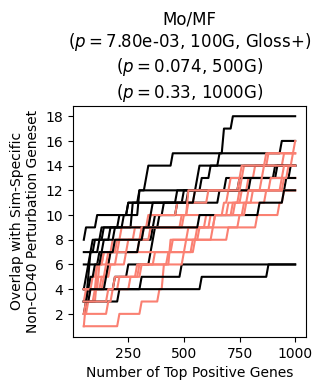

In [114]:
plt.figure(figsize=(3,3))
for i in range(10):
    #if i == 3:
    #    continue
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey + str(i)], label='Gloss coefs', color='black')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey + str(i)], label='correlations', color='salmon')
plt.xlabel('Number of Top Positive Genes')
plt.ylabel('Overlap with Sim-Specific\nNon-CD40 Perturbation Geneset'.format(mykey))
#plt.legend()
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(f'{ctype}\n($p=${mytres_100:.2e}, 100G, Gloss+)\n($p=${mytres_500:.2}, 500G)\n($p=${mytres_1000:.2}, 1000G)')

Text(0.5, 1.0, 'cDC2\n($p=$1.64e-03, 100G, Gloss+)\n($p=$0.54, 500G)\n($p=$0.66, 1000G)')

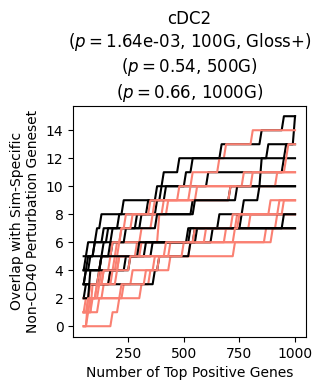

In [126]:
plt.figure(figsize=(3,3))
for i in range(10):
    #if i == 3:
    #    continue
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey + str(i)], label='Gloss coefs', color='black')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey + str(i)], label='correlations', color='salmon')
plt.xlabel('Number of Top Positive Genes')
plt.ylabel('Overlap with Sim-Specific\nNon-CD40 Perturbation Geneset'.format(mykey))
#plt.legend()
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(f'{ctype}\n($p=${mytres_100:.2e}, 100G, Gloss+)\n($p=${mytres_500:.2}, 500G)\n($p=${mytres_1000:.2}, 1000G)')

Text(0.5, 1.0, 'mRegDC2\n($p=$2.31e-03, 100G, Gloss+)\n($p=$7.66e-03, 500G, Gloss+)\n($p=$0.19, 1000G)')

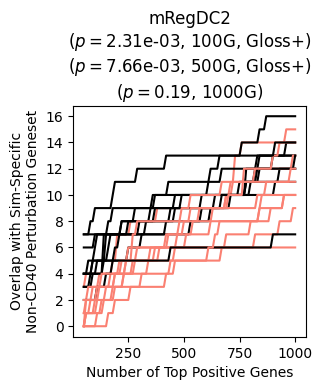

In [139]:
plt.figure(figsize=(3,3))
for i in range(10):
    #if i == 3:
    #    continue
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey + str(i)], label='Gloss coefs', color='black')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey + str(i)], label='correlations', color='salmon')
plt.xlabel('Number of Top Positive Genes')
plt.ylabel('Overlap with Sim-Specific\nNon-CD40 Perturbation Geneset'.format(mykey))
#plt.legend()
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(f'{ctype}\n($p=${mytres_100:.2e}, 100G, Gloss+)\n($p=${mytres_500:.2e}, 500G, Gloss+)\n($p=${mytres_1000:.2}, 1000G)')